In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import zero_one_loss

# Exercise 5

Binary classification. 

Plotting class-conditional distributions and η(x) = P(Y = 1 | X = x)

In [ ]:
x1 = np.linspace(0,1,50)
x2 = np.linspace(1,2,50)
x3 = np.linspace(2,3,50)

plt.figure(figsize=(15,7))

#P(X|Y=0)
plt.plot(np.hstack((x1,x2)),np.hstack((x1/2,x2/2)), linestyle = "dashed",color = sns.xkcd_rgb["dark yellow"])

#P(X|Y=1)
plt.plot(np.hstack((x2,x3)),np.hstack((x1/(x1*2),x2/(x2*2))),linestyle = "dashed",color = sns.xkcd_rgb["sea blue"])

#fx
plt.plot(x1,x1/4,color = 'black')
plt.plot(x1,x1*0,color=sns.xkcd_rgb["sea blue"])#eta(x) per legend grafic
plt.plot(x1,1-x1*0,color = sns.xkcd_rgb["dark yellow"])#eta(x) per legend grafic

plt.plot(x2,x2/4+1/4,color = 'black')
plt.plot(x3,x3/x3*1/4,color='black')

#eta(x)

plt.plot(x2,1/(1+x2),color=sns.xkcd_rgb["sea blue"])
plt.plot(x3,x3*1/x3,color=sns.xkcd_rgb["sea blue"])

#1-eta(x)
plt.plot(x2,1-1/(1+x2),color = sns.xkcd_rgb["dark yellow"])
plt.plot(x3,1-x3*1/x3,color = sns.xkcd_rgb["dark yellow"])

plt.axvline(x=2,linewidth = 2,color = sns.xkcd_rgb["scarlet"])
#plt.axvspan(xmin=2,xmax=3,color=sns.xkcd_rgb["sea blue"],alpha = 0.1)
#plt.axvspan(xmin=0,xmax=2,color = sns.xkcd_rgb["mustard"],alpha = 0.1)


plt.xlabel("x", fontsize = 18)
plt.text(1.65,0.85,"g*   0 <-    -> 1",color = sns.xkcd_rgb["scarlet"], fontsize = 18)
plt.legend(["$f_{X|Y=0}$","$f_{X|Y=1}$","$f_x$","$\eta(x)$","$1-\eta(x)$"],loc=5,fontsize = 12)
plt.grid(True)
plt.savefig("Ex1_distributions",bbox_inches = 'tight')

# Exercise 7

Binary classification with KNN

## Part1

Classify data using 1,3,5,7,9 -NN varying the dimensions (d) and size of sample (n)

In [1]:
# Estimating risk for classification rule (K-NN) given n and d with MonteCarlo
def K_class_risk(K,n,d,redraws,cv=10):
    
    mean_risk = []
    classif = []
    bayes_risk=[]
    
    for i,neigh in enumerate(K):
        
        classif.append(KNeighborsClassifier(n_neighbors=neigh))
        k_risk=[]
        
        
        for redraw in enumerate(range(redraws)):
            
            np.random.seed(redraw)
            X = np.reshape(np.random.uniform(size=n*d),(n,d))
            Y = np.random.binomial(1,X[:,0])
            
            #-- NN risk 
            classif[i].fit(X,Y)
            k_risk.append(np.mean(1-cross_val_score(classif[i], X, Y, cv=cv,scoring = 'accuracy')))
            
            #-- Bayes risk
            if neigh == 1:
                predY = [0 if x<0.5 else 1 for x in X[:,0]]
                bayes_risk.append(zero_one_loss(Y,predY))
            
        mean_risk.append(np.mean(k_risk))
    return (np.hstack((mean_risk,np.mean(bayes_risk))))   


In [ ]:
ns=[25,100,1000]
ds=np.arange(1,200,10)
redraws = 50
K = [1,3,5,7,9]
risk=np.zeros((len(ds),len(K)+1,len(ns)))

for i,n in enumerate(ns):
    for l,d in enumerate(ds):
            risk[l,:,i] = K_class_risk(K,n,d,redraws,cv=5)

In [ ]:
# Plotting results

fig,axes= plt.subplots(nrows = 1, ncols = 3, figsize = (15,5),sharey=True,sharex = True)

for i,n in enumerate(ns):
    
    colors = sns.color_palette("BrBG",6).as_hex()
    axes[i].set_prop_cycle('color',colors)    
    axes[i].plot(ds,risk[:,:,i])
    axes[i].set_xlabel("d",fontsize=15)
    axes[i].set_ylabel("$R$",fontsize=15)
    axes[i].grid(True)
    axes[i].set_title(f"n = {n}",fontsize = 12,fontweight = 1000)
    axes[i].axhline(y=0.25,color=colors[5],linestyle = ':')
    axes[i].axhline(y=1/3, color= colors[0],linestyle = ':')
    axes[i].axhline(y=3/10, color= colors[2],linestyle = ':')

fig.legend(["1-NN","3-NN","5-NN","7-NN","9-NN","Bayes","R*","R1-nn","R3-nn"],loc=5)
fig.savefig("Risk_function_d",bbox_inches='tight')

## Part 2

Estimating the probability of error of best rule found by empirical risk minimization (using independent test data) and comparing it to the probability of error of the best of these five classification rules.

In [4]:
def generate_data(n,d):
    X = np.reshape(np.random.uniform(size=n*d),(n,d))
    Y = np.random.binomial(1,X[:,0])
    return (X,Y)

def fit_models(K,X,Y):
    classif = []
    for i,neigh in enumerate(K):
        classif.append(KNeighborsClassifier(n_neighbors=neigh))
        classif[i].fit(X,Y)
    return(classif)

def compute_classifier_errors(classifiers, X,Y):
    class_risk = []
    for i,k in enumerate(classifiers):    
        class_risk.append(zero_one_loss(Y,classifiers[i].predict(X)))
    
    return (np.array(class_risk)) 

def compute_error_rule(n,d,m,l): 
    
    #--- Fitting to Dn ---#
    Xn,Yn =generate_data(n,d)
    classifiers = fit_models(K,Xn,Yn)
    
    #--- Testing on Dm ---#
    Xm,Ym = generate_data(m,d)
    k_risk_m = compute_classifier_errors(classifiers,Xm,Ym)
    lowest_risk_class_m = np.argmin(k_risk_m) # Choose classifier with lower risk regardind Dm
    
    #--- Testing on Dl ---#
    Xl,Yl = generate_data(n,d)
    k_risk_l = compute_classifier_errors(classifiers,Xl,Yl)
    lowest_risk_class_l= np.argmin(k_risk_l) # Choose classifier with lower risk regardind Dl
    
    return(lowest_risk_class_m, k_risk_m[-1],lowest_risk_class_l,k_risk_l[lowest_risk_class_m])
    

In [12]:
n = 1000
ds = [2]#,10]
ls = 500
K = [1,3,5,7,9]
ms = np.arange(25,1500,100)

In [13]:
np.random.seed(2)
    
dimensions = {}
best_risk = {}
best_risk9 = {}

for d in ds:
        
    chosen_class_m = [] #Probability of chossing the right classifier based on Dm (test_data)
    chosen_class_l = []
    
    av_risk_l = []
    av_risk_m9 = []

    # For different sizes m of test data
    for m in ms:     

        lowest_risk_class_m = []
        lowest_risk_class_l = []
        
        emp_risk_m_9 = []
        emp_risk_l = []

        for l in range(ls):

            a, risk_m_9, b, risk_l = compute_error_rule(n,d,m,l)

            lowest_risk_class_m.append(a)
            lowest_risk_class_l.append(b)
            
            emp_risk_m_9.append(risk_m_9)
            emp_risk_l.append(risk_l)

        # Compute frequencies
        chosen_class_m.append(list(np.bincount(lowest_risk_class_m)/ls))
        chosen_class_l.append(list(np.bincount(lowest_risk_class_l)/ls))        
        
        av_risk_m9.append(np.mean(emp_risk_m_9))
        av_risk_l.append(np.mean(emp_risk_l))       
    
    dimensions[d] = np.array(chosen_class_m).T
    #np.vstack((np.array(chosen_class_m).T,np.array(chosen_class_l)[:,4])).T
    
    best_risk9[d] =np.array(av_risk_m9)
    best_risk[d] = np.array(av_risk_l)

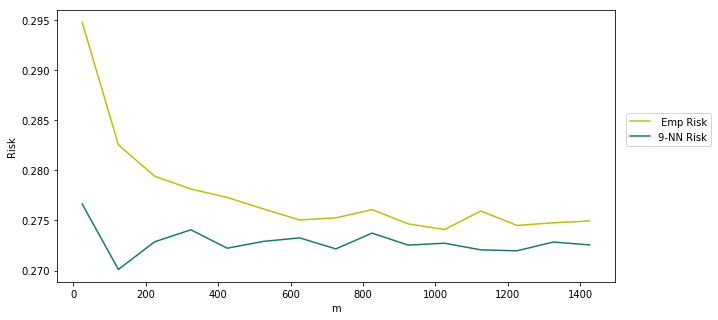

In [14]:
fig,axes= plt.subplots(nrows = 1, ncols = 1, figsize = (10,5),sharey=True,sharex = True)

axes.plot(ms,best_risk.get(2),color = 'y')
axes.plot(ms,best_risk9.get(2), color = sns.color_palette("BrBG",6).as_hex()[-1])
axes.legend([" Emp Risk","9-NN Risk"],loc = (1.02,0.5))
axes.set_xlabel("m",fontsize=10)
axes.set_ylabel("Risk",fontsize=10)
fig.savefig("Error_conv",bbox_inches='tight')

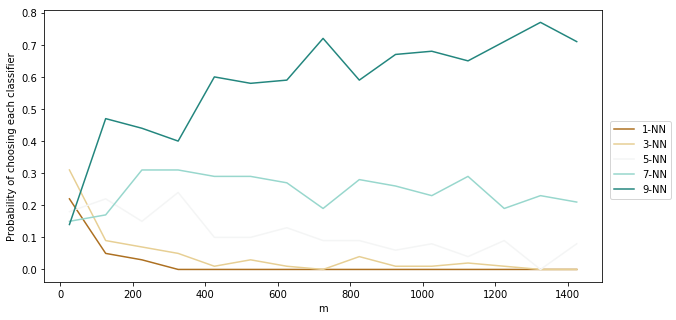

In [9]:
fig,axes= plt.subplots(nrows = 1, ncols = 1, figsize = (10,5),sharey=True,sharex = True)
colors = sns.color_palette("BrBG",5).as_hex()

axes.set_prop_cycle('color',colors)    
axes.plot(ms,dimensions.get(2).T)
axes.set_xlabel("m",fontsize=10)
axes.set_ylabel("Probability of choosing each classifier",fontsize=10)

fig.legend(["1-NN","3-NN","5-NN","7-NN","9-NN"],loc = 5)
fig.savefig("Prob_classfiers",bbox_inches='tight')
